# DRL_PFOpt_XP - Stable Baselines3 Mods Tests
#### 2022/11/13, AJ Zerouali

Goals:

* Test preliminary version of sb3_mods module.
* Plot training and validation losses for TD3, SAC, RecurrentPPO, and TRPO.

## Imports and Dow Jones Data

In [1]:
# Kill warnings
from warnings import filterwarnings
filterwarnings("ignore")

### Basics
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
#matplotlib.use('Agg')
%matplotlib inline
import datetime
import itertools

### OpenAI Gym and StableBaselines3
from gym.utils import seeding
import gym
from gym import spaces
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise

### What is this?
import sys

### My imports (22/11/04, AJ Zerouali)
import DRL_PFOpt_Utils
import DRL_PFOpt_Data
import DRL_PFOpt_gymEnv
import DRL_PFOpt_Agent

# Experimental implementations
from DRL_PFOpt_XP import PFOptEnv_XP

# Load Dow Jones data
df_file = pd.read_csv(filepath_or_buffer="datasets/DJIA30_data_0801-0908.csv",
                           usecols = ['date', 'open', 'high', 'low', 'close', 'volume', 'tic'])

# Instantiate feature engineering object
FeatureEng = DRL_PFOpt_Data.FeatureEngineer(tech_indicator_list = ["turbulence"],
                                                 use_return_covs = True,
                                                 n_lookback_prds = 90)

# Preprocess df_file
df_X, np_close_returns, np_returns_cov = FeatureEng.preprocess_data(df_X = df_file)

Successfully computed asset returns and their covariances
Successfully added technical indicators
Successfully added turbulence index


In [2]:
# Train and test dates
start_train_date = '2008-12-31'
end_train_date = '2020-07-01'
start_test_date = end_train_date
end_test_date = '2021-09-02'

In [3]:
df_train, ret_X_train, cov_X_train = DRL_PFOpt_Data.data_split(df_X = df_X, 
                                                                    start=start_train_date, 
                                                                    end = end_train_date,
                                                                    use_returns_cov = True,
                                                                    ret_X= np_close_returns,
                                                                    cov_X=np_returns_cov)

Dataframe, returns and cov have same number of dates


In [4]:
df_test, ret_X_test, cov_X_test = DRL_PFOpt_Data.data_split(df_X = df_X, 
                                                                    start=start_test_date, 
                                                                    end = end_test_date,
                                                                    use_returns_cov = True,
                                                                    ret_X= np_close_returns,
                                                                    cov_X=np_returns_cov)

Dataframe, returns and cov have same number of dates


In [5]:
# Validation

start_val_date = end_train_date
end_val_date = "2020-09-30"
df_val, ret_X_val, cov_X_val = DRL_PFOpt_Data.data_split(df_X = df_X,
                                                         start=start_val_date, 
                                                         end = end_val_date,
                                                         use_returns_cov = True,
                                                         ret_X= np_close_returns,
                                                         cov_X=np_returns_cov)

Dataframe, returns and cov have same number of dates


**Get benchmark data**

Benchmark data (DJIA) over testing dates.

In [6]:
df_DJI_benchmark, df_DJI_returns = DRL_PFOpt_Utils.get_benchmark_prices_and_returns(
                    ticker = "^DJI", start_date = '2020-07-01', end_date = '2021-09-02')

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (296, 8)


In [7]:
DJI_cumul_return = (df_DJI_benchmark['close'].iloc[-1]\
                    -df_DJI_benchmark['close'].iloc[0])/(df_DJI_benchmark['close'].iloc[0])
DJI_Sharpe = (np.sqrt(252)*df_DJI_returns['daily_return'].to_numpy().mean())\
    /(df_DJI_returns['daily_return'].to_numpy().std())
print(f"Benchmark cumul. ret.: {DJI_cumul_return}")
print(f"Benchmark Sharpe ratio: {DJI_Sharpe}")

Benchmark cumul. ret.: 0.3721613153308154
Benchmark Sharpe ratio: 2.0157856997458663


Benchmark data (DJIA) over **validation** dates.

In [8]:
df_DJI_benchmark_val, df_DJI_returns_val = DRL_PFOpt_Utils.get_benchmark_prices_and_returns(
                    ticker = "^DJI", start_date = start_val_date, end_date = end_val_date)

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (63, 8)


In [9]:
DJI_cumul_return_val = (df_DJI_benchmark_val['close'].iloc[-1]\
                    -df_DJI_benchmark_val['close'].iloc[0])/(df_DJI_benchmark_val['close'].iloc[0])
DJI_Sharpe_val = (np.sqrt(252)*df_DJI_returns_val['daily_return'].to_numpy().mean())\
    /(df_DJI_returns['daily_return'].to_numpy().std())
print(f"Benchmark cumul. ret.: {DJI_cumul_return_val}")
print(f"Benchmark Sharpe ratio: {DJI_Sharpe_val}")

Benchmark cumul. ret.: 0.06674534325063058
Benchmark Sharpe ratio: 2.0423967471898394


## Agent

In [10]:
'''
    ###################
    ###  NEW AGENT  ###
    ###################
    ## AJ Zerouali, 22/11/13
'''
## Usual
# Stable Baselines 3 imports
from stable_baselines3 import A2C
from stable_baselines3 import DDPG
from stable_baselines3 import PPO
from stable_baselines3 import SAC
from stable_baselines3 import TD3
####################
## NEW (22/11/13) ##
####################
from sb3_contrib import RecurrentPPO
from sb3_contrib import TRPO

from stable_baselines3.common.base_class import BaseAlgorithm
from stable_baselines3.common.on_policy_algorithm import OnPolicyAlgorithm
from stable_baselines3.common.off_policy_algorithm import OffPolicyAlgorithm
from stable_baselines3.common.policies import BaseModel, BasePolicy

# NOTE (22/11/11): ProgressBarCallback requires the rich package.
from stable_baselines3.common.callbacks import BaseCallback, StopTrainingOnNoModelImprovement, EvalCallback, CallbackList, ProgressBarCallback
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise
from stable_baselines3.common.vec_env import DummyVecEnv


## NEW 22/11/13
from sb3_mods.td3 import TD3_mod


# Global variables
MODELS = {"a2c": A2C, "ddpg": DDPG, "td3": TD3, "sac": SAC, "ppo": PPO, "recurrent_ppo":RecurrentPPO, "trpo":TRPO,
          "td3_mod": TD3_mod,
         }
NOISE = {"normal": NormalActionNoise,
        "ornstein_uhlenbeck": OrnsteinUhlenbeckActionNoise,
        }
# Model Parameters (borrowed from FinRL)
A2C_PARAMS = {"n_steps": 5, "ent_coef": 0.01, "learning_rate": 0.0007}
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 64,
} 
DDPG_PARAMS = {"batch_size": 128, "buffer_size": 50000, "learning_rate": 0.001}
TD3_PARAMS = {"batch_size": 100, "buffer_size": 1000000, "learning_rate": 0.001}
SAC_PARAMS = {
    "batch_size": 64,
    "buffer_size": 100000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}
# MODEL_KWARGS = {x: config.__dict__[f"{x.upper()}_PARAMS"] for x in MODELS.keys()}
MODEL_KWARGS = {"a2c":A2C_PARAMS, "ppo":PPO_PARAMS,
                "ddpg":DDPG_PARAMS, "td3":TD3_PARAMS,
                "sac":SAC_PARAMS,}


################################
### EXPERIMENTAL AGENT CLASS ###
################################
## 22/11/13, AJ Zerouali


class PFOptAgent_XP(DRL_PFOpt_Agent.PFOpt_DRL_Agent):
    
    #######################
    ### Le constructeur ###
    #######################
    def __init__(self, 
                 train_env: PFOptEnv_XP, # NOTE NEW CLASS
                 test_env: PFOptEnv_XP=None, # NOTE NEW CLASS
                 model_fname: str = None,
                 ):
        # Get superclass object
        super().__init__(train_env = train_env,                         
                         test_env = test_env,
                         model_fname = model_fname,)
        
        # Temp (22/11/13): For additional
        self.model_is_sb3_mod = None
        
        # Agent actions history
        self.agt_action_hist = None
    
    #################################
    ### Deep RL agent initializer ###
    #################################
    ### 22/10/19, AJ Zerouali
    ### IMPORTANT: Formerly "get_model"
    def set_model(self,
                  model_name,
                  policy="MlpPolicy",
                  policy_kwargs=None,
                  model_kwargs=None,
                  verbose=1,
                  seed=None,
                  tensorboard_log=None,
                 ):
        '''
            Initialize the agent's self.model attribute with an SB3 algorithm.
            Wraps the stable_baselines3 model constructor.
        '''
        
        if model_name not in MODELS:
            raise NotImplementedError("NotImplementedError")

        if model_kwargs is None:
            model_kwargs = MODEL_KWARGS[model_name]

        if "action_noise" in model_kwargs:
            n_actions = self.train_env.action_space.shape[-1]
            model_kwargs["action_noise"] = NOISE[model_kwargs["action_noise"]](
                mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions)
            )
        print(model_kwargs)
        
        # New, 22/11/13
        self.model_is_sb3_mod = ("mod" in model_name)
        
        # Instantiate SB3 Algorithm
        self.model = MODELS[model_name](policy=policy,
                                        env=self.train_env,
                                        tensorboard_log=tensorboard_log,
                                        verbose=verbose,
                                        policy_kwargs=policy_kwargs,
                                        seed=seed,
                                        **model_kwargs,
                                       )
        
        # Initialize training/testing Boolean attributes
        self.model_is_trained = False
        self.ran_backtest = False
        
        print(f"{model_name} with given parameters has been successfully created.")
        return True
    
    #############################
    ### Agent training method ###
    #############################
    # 22/11/11, AJ Zerouali
    # Updated param to n_train_rounds instead of total timesteps
    # total_timesteps = n_train_rounds*train_env.N_periods.
    def train_model(self, tb_log_name: str, 
                    n_train_rounds: int = 20,
                    save_model = False, 
                    model_fname: str = None,
                    progress_bar: bool =False,# NEW 22/11/13
                    model_callback: BaseCallback = None,
                   ):
        '''
            Trains the model attribute according to the given parameters.
            Wrapper for stable_baselines3's BaseAlgorithm.learn() method.
            Notes (22/10/19): 
            1) Add more training attributes to this agent class.
            2) Use context manager below for training?
            
            :param tb_log_name: Log name for TensorBoard
            :param n_train_rounds: Number of episodes for training.
                Determines total number of times that train_env.step() is
                called, with total_timesteps = n_train_rounds*train_env.N_periods.
            :param save_model: Whether or not to call save_model() at end of training.
            :param model_fname: Filename for saved zip file containing SB3 model.
            
            
        '''
        # Init. training attributes
        self.model_tb_log_name = tb_log_name
        self.model_callback = model_callback # Note (22/11/11): Made this into a BaseCallback param
        
        # Get total timesteps from no. of training rounds
        total_timesteps = n_train_rounds*self.train_env.N_periods
        
        # Call learn()
        self.model.learn(total_timesteps=total_timesteps,
                         tb_log_name=self.model_tb_log_name,
                         progress_bar = progress_bar,
                         callback=self.model_callback,
                         )
        self.model_is_trained = True
        
        # Save model if required
        if save_model:
            self.save_model(model_fname= model_fname)
        
        # New 22/11/13: Get losses
        if self.model_is_sb3_mod:
            return self.model.losses_dict
    
    
    
    ####################################
    ###     CRUCIAL: Run Backtest    ###
    ####################################
    ## 22/11/04
    def run_backtest(self, 
                     test_env: PFOptEnv_XP = None, 
                     deterministic=True,
                     ):
        '''
            Runs backtest in the specified test environment.
            If the agent already has a test environment, 
            it is overwritten by the given test_env parameter.
            Outputs 2 pd.DataFrames: The history of portfolio values
            and the history of portfolio weights, at end of each
            trading period 
            Note (22/10/19): The only period supported for now is daily.
        '''
        # Check if agent is trained and update test environment
        if not self.model_is_trained:
            print("ERROR: Cannot run a backtest with an untrained agent")
            return None, None, None, None
        else:
            if test_env != None:
                self.set_test_env(test_env=test_env)
            
        # Check if there's a test environment
        if self.test_env == None:
            print("ERROR: No test environment provided to run a backtest.")
            return None, None, None, None
        else: # This is where backtest starts
            
            # Reset SB3 test environment, get initial state
            state = self.test_env.reset()

            # IMPORTANT (22/10/20): From my modifed PortfolioOptEnv
            ## SB3's get_attr() returns a list for some reason.
            N_periods = self.test_env.get_attr(attr_name = "N_periods")[0]
            
            
            # Main loop
            for i in range(N_periods): # Needs to be changed
                
                # Compute action corresponding to current observation
                action, state_ = self.model.predict(state, deterministic=deterministic)
                
                # Execute the step() function
                ### WARNING (22/10/19): I don't see state_ being reused here. C'est normal ça?
                state, rewards, dones, info = self.test_env.step(action)
                
                
                # Store history
                if i == (N_periods - 2): 
                    # Important: i = (N_periods-2) is when the environment's t_idx is updated to (N_periods-1)
                    # The assignment is done here because SB3 automatically resets the environment to t_idx = 0
                    pf_value_hist = self.test_env.env_method(method_name="get_pf_value_hist")[0]
                    pf_return_hist = self.test_env.env_method(method_name="get_pf_return_hist")[0]
                    pf_weights_hist = self.test_env.env_method(method_name="get_pf_weights_hist")[0]
                    agt_action_hist = self.test_env.env_method(method_name="get_agt_action_hist")[0] # NEW (22/11/04)
                 
                if dones[0]:
                    # These are 
                    print("Finished running backtest. Storing results...")
                    self.pf_value_hist = pf_value_hist
                    self.pf_return_hist = pf_return_hist
                    self.pf_weights_hist = pf_weights_hist
                    self.agt_action_hist = agt_action_hist # NEW (22/11/04)
                    self.ran_backtest = True
                    break # Why?
                
            return self.pf_value_hist, self.pf_return_hist, self.pf_weights_hist, self.agt_action_hist

### 

## TD3 Mods, Seed = 119

In [11]:
# Env params
n_lookback_prds = 90
pf_value_ini = 1000000
reward_type= 'portfolio_return'
state_struct_list = ['open','high','low','close', 'volume', 'weights']
tech_ind_list = []
transaction_cost_pct = 0
weight_normalization = "relu"

In [12]:
train_env_OHLCVW = PFOptEnv_XP(
            df_X = df_train,
            cov_X = cov_X_train,
            n_lookback_prds = n_lookback_prds,
            pf_value_ini = pf_value_ini,
            reward_type = reward_type,
            state_struct_list = state_struct_list,
            tech_ind_list = tech_ind_list,
            transaction_cost_pct= transaction_cost_pct,
            weight_normalization = weight_normalization)

In [13]:
test_env_OHLCVW = PFOptEnv_XP(
            df_X = df_test,
            cov_X = cov_X_test,
            n_lookback_prds = n_lookback_prds,
            pf_value_ini = pf_value_ini,
            reward_type = reward_type,
            state_struct_list = state_struct_list,
            tech_ind_list = tech_ind_list,
            transaction_cost_pct= transaction_cost_pct,
            weight_normalization = weight_normalization)

In [14]:
eval_env_OHLCVW = PFOptEnv_XP(
            df_X = df_val,
            cov_X = cov_X_val,
            n_lookback_prds = n_lookback_prds,
            pf_value_ini = pf_value_ini,
            reward_type = reward_type,
            state_struct_list = state_struct_list,
            tech_ind_list = tech_ind_list,
            transaction_cost_pct= transaction_cost_pct,
            weight_normalization = weight_normalization)

In [15]:
train_env_OHLCVW.N_periods

2894

In [31]:
del TD3_mod_OHCLVW, eval_callback, stop_training_callback

In [32]:
# Instantiate agent
TD3_mod_OHCLVW = PFOptAgent_XP(train_env = train_env_OHLCVW)

In [33]:
TD3_PARAMS = {"batch_size": 256, 
              "buffer_size": 10000,
              "learning_rate": 0.01,
              "gamma":0,
              "train_freq": (5, "step"),
              "policy_delay":1,
              "learning_starts":5,
              "action_noise":"ornstein_uhlenbeck",}

TD3_mod_OHCLVW.set_model(model_name = "td3_mod",
                     seed = 119,
                     model_kwargs=TD3_PARAMS)

{'batch_size': 256, 'buffer_size': 10000, 'learning_rate': 0.01, 'gamma': 0, 'train_freq': (5, 'step'), 'policy_delay': 1, 'learning_starts': 5, 'action_noise': OrnsteinUhlenbeckActionNoise(mu=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.], sigma=[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1])}
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
td3_mod with given parameters has been successfully created.


True

In [34]:
stop_training_callback = StopTrainingOnNoModelImprovement(max_no_improvement_evals=3,
                                                          min_evals = 2,
                                                          verbose=1)
eval_callback = EvalCallback(eval_env=eval_env_OHLCVW, 
                             eval_freq=train_env_OHLCVW.N_periods, 
                             callback_after_eval=stop_training_callback, 
                             verbose=1)

In [35]:
loss_dict = TD3_mod_OHCLVW.train_model(tb_log_name='td3_mod',
                                       n_train_rounds=12,
                                       model_callback = eval_callback,
                                      progress_bar = True,
                                      )

Output()

=================================

Initial portfolio value: 1000000

End portfolio value: 7223292.466625194

Yearly Sharpe ratio at last period: 0.9573525891332446

=================================

=================================

Initial portfolio value: 1000000

End portfolio value: 1117136.2561754768

Yearly Sharpe ratio at last period: 2.775804940209787

=================================

=================================

Initial portfolio value: 1000000

End portfolio value: 1117136.2561754768

Yearly Sharpe ratio at last period: 2.775804940209787

=================================

=================================

Initial portfolio value: 1000000

End portfolio value: 1117136.2561754768

Yearly Sharpe ratio at last period: 2.775804940209787

=================================

=================================

Initial portfolio value: 1000000

End portfolio value: 1117136.2561754768

Yearly Sharpe ratio at last period: 2.775804940209787

=================================

=================================

Initial portfolio value: 1000000

End portfolio value: 1117136.2561754768

Yearly Sharpe ratio at last period: 2.775804940209787

=================================

Eval num_timesteps=2894, episode_reward=0.11 +/- 0.00

Episode length: 63.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 63       |
|    mean_reward     | 0.108    |
| time/              |          |
|    total_timesteps | 2894     |
| train/             |          |
|    actor_loss      | -109     |
|    critic_loss     | 1.4e+07  |
|    learning_rate   | 0.01     |
|    n_updates       | 2885     |
---------------------------------


New best mean reward!

=================================

Initial portfolio value: 1000000

End portfolio value: 7438363.360583425

Yearly Sharpe ratio at last period: 0.9678809779107805

=================================

=================================

Initial portfolio value: 1000000

End portfolio value: 1117136.2561754768

Yearly Sharpe ratio at last period: 2.775804940209787

=================================

=================================

Initial portfolio value: 1000000

End portfolio value: 1117136.2561754768

Yearly Sharpe ratio at last period: 2.775804940209787

=================================

=================================

Initial portfolio value: 1000000

End portfolio value: 1117136.2561754768

Yearly Sharpe ratio at last period: 2.775804940209787

=================================

=================================

Initial portfolio value: 1000000

End portfolio value: 1117136.2561754768

Yearly Sharpe ratio at last period: 2.775804940209787

=================================

=================================

Initial portfolio value: 1000000

End portfolio value: 1117136.2561754768

Yearly Sharpe ratio at last period: 2.775804940209787

=================================

Eval num_timesteps=5788, episode_reward=0.11 +/- 0.00

Episode length: 63.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 63       |
|    mean_reward     | 0.108    |
| time/              |          |
|    total_timesteps | 5788     |
| train/             |          |
|    actor_loss      | 248      |
|    critic_loss     | 6.5e+06  |
|    learning_rate   | 0.01     |
|    n_updates       | 5780     |
---------------------------------


=================================

Initial portfolio value: 1000000

End portfolio value: 7436487.8930344125

Yearly Sharpe ratio at last period: 0.9673152091361239

=================================

=================================

Initial portfolio value: 1000000

End portfolio value: 1117136.2561754768

Yearly Sharpe ratio at last period: 2.775804940209787

=================================

=================================

Initial portfolio value: 1000000

End portfolio value: 1117136.2561754768

Yearly Sharpe ratio at last period: 2.775804940209787

=================================

=================================

Initial portfolio value: 1000000

End portfolio value: 1117136.2561754768

Yearly Sharpe ratio at last period: 2.775804940209787

=================================

=================================

Initial portfolio value: 1000000

End portfolio value: 1117136.2561754768

Yearly Sharpe ratio at last period: 2.775804940209787

=================================

=================================

Initial portfolio value: 1000000

End portfolio value: 1117136.2561754768

Yearly Sharpe ratio at last period: 2.775804940209787

=================================

Eval num_timesteps=8682, episode_reward=0.11 +/- 0.00

Episode length: 63.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 63       |
|    mean_reward     | 0.108    |
| time/              |          |
|    total_timesteps | 8682     |
| train/             |          |
|    actor_loss      | -0.227   |
|    critic_loss     | 6.3e+06  |
|    learning_rate   | 0.01     |
|    n_updates       | 8675     |
---------------------------------


=================================

Initial portfolio value: 1000000

End portfolio value: 7478641.232163871

Yearly Sharpe ratio at last period: 0.9685950192039643

=================================

=================================

Initial portfolio value: 1000000

End portfolio value: 1117136.2561754768

Yearly Sharpe ratio at last period: 2.775804940209787

=================================

=================================

Initial portfolio value: 1000000

End portfolio value: 1117136.2561754768

Yearly Sharpe ratio at last period: 2.775804940209787

=================================

=================================

Initial portfolio value: 1000000

End portfolio value: 1117136.2561754768

Yearly Sharpe ratio at last period: 2.775804940209787

=================================

=================================

Initial portfolio value: 1000000

End portfolio value: 1117136.2561754768

Yearly Sharpe ratio at last period: 2.775804940209787

=================================

=================================

Initial portfolio value: 1000000

End portfolio value: 1117136.2561754768

Yearly Sharpe ratio at last period: 2.775804940209787

=================================

Eval num_timesteps=11576, episode_reward=0.11 +/- 0.00

Episode length: 63.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 63       |
|    mean_reward     | 0.108    |
| time/              |          |
|    total_timesteps | 11576    |
| train/             |          |
|    actor_loss      | 68.2     |
|    critic_loss     | 5.65e+06 |
|    learning_rate   | 0.01     |
|    n_updates       | 11570    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.89e+03 |
|    ep_rew_mean     | 2.25     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 23       |
|    time_elapsed    | 502      |
|    total_timesteps | 11576    |
---------------------------------


=================================

Initial portfolio value: 1000000

End portfolio value: 7443985.235785169

Yearly Sharpe ratio at last period: 0.9698263330732869

=================================

=================================

Initial portfolio value: 1000000

End portfolio value: 1117136.2561754768

Yearly Sharpe ratio at last period: 2.775804940209787

=================================

=================================

Initial portfolio value: 1000000

End portfolio value: 1117136.2561754768

Yearly Sharpe ratio at last period: 2.775804940209787

=================================

=================================

Initial portfolio value: 1000000

End portfolio value: 1117136.2561754768

Yearly Sharpe ratio at last period: 2.775804940209787

=================================

=================================

Initial portfolio value: 1000000

End portfolio value: 1117136.2561754768

Yearly Sharpe ratio at last period: 2.775804940209787

=================================

=================================

Initial portfolio value: 1000000

End portfolio value: 1117136.2561754768

Yearly Sharpe ratio at last period: 2.775804940209787

=================================

Eval num_timesteps=14470, episode_reward=0.11 +/- 0.00

Episode length: 63.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 63       |
|    mean_reward     | 0.108    |
| time/              |          |
|    total_timesteps | 14470    |
| train/             |          |
|    actor_loss      | 69.9     |
|    critic_loss     | 6.88e+05 |
|    learning_rate   | 0.01     |
|    n_updates       | 14460    |
---------------------------------


=================================

Initial portfolio value: 1000000

End portfolio value: 7506200.147825672

Yearly Sharpe ratio at last period: 0.9704808666086822

=================================

=================================

Initial portfolio value: 1000000

End portfolio value: 1117136.2561754768

Yearly Sharpe ratio at last period: 2.775804940209787

=================================

=================================

Initial portfolio value: 1000000

End portfolio value: 1117136.2561754768

Yearly Sharpe ratio at last period: 2.775804940209787

=================================

=================================

Initial portfolio value: 1000000

End portfolio value: 1117136.2561754768

Yearly Sharpe ratio at last period: 2.775804940209787

=================================

=================================

Initial portfolio value: 1000000

End portfolio value: 1117136.2561754768

Yearly Sharpe ratio at last period: 2.775804940209787

=================================

=================================

Initial portfolio value: 1000000

End portfolio value: 1117136.2561754768

Yearly Sharpe ratio at last period: 2.775804940209787

=================================

Eval num_timesteps=17364, episode_reward=0.11 +/- 0.00

Episode length: 63.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 63       |
|    mean_reward     | 0.108    |
| time/              |          |
|    total_timesteps | 17364    |
| train/             |          |
|    actor_loss      | -61.6    |
|    critic_loss     | 2.03e+06 |
|    learning_rate   | 0.01     |
|    n_updates       | 17355    |
---------------------------------


Stopping training because there was no new best model in the last 4 evaluations

In [36]:
%matplotlib inline

In [37]:
len(loss_dict["actor_losses"])

5

<AxesSubplot:>

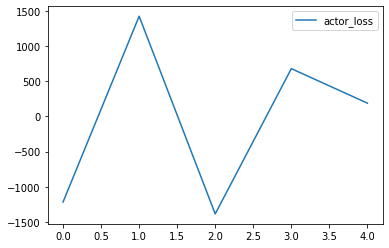

In [38]:
pd.DataFrame({"actor_loss":loss_dict["actor_losses"]}).plot()

In [39]:
loss_dict["critic_losses"]

[1525052.125, 2439275.5, 2807281.75, 2451841.25, 904582.1875]

<AxesSubplot:>

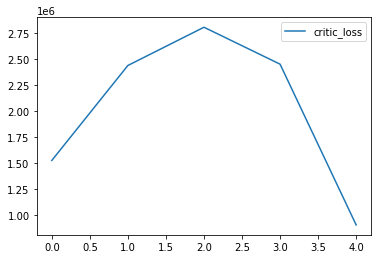

In [40]:
pd.DataFrame({"critic_loss":loss_dict["critic_losses"]}).plot()

In [41]:
df_pf_value_hist_det, df_pf_return_hist_det, \
df_pf_weights_hist_det, df_agt_action_hist_det\
 = TD3_mod_OHCLVW.run_backtest(test_env = test_env_OHLCVW,)

Initial portfolio value: 1000000
End portfolio value: 1601091.9968540422
Yearly Sharpe ratio at last period: 2.7480577501470793
Finished running backtest. Storing results...


In [41]:
df_pf_value_hist_det, df_pf_return_hist_det, \
df_pf_weights_hist_det, df_agt_action_hist_det\
 = TD3_mod_OHCLVW.run_backtest(test_env = eval_env_OHLCVW,)

Initial portfolio value: 1000000
End portfolio value: 1117136.2561754768
Yearly Sharpe ratio at last period: 2.775804940209787
Finished running backtest. Storing results...


Start date,2020-07-01
End date,2020-09-29
Total months,3
,Backtest
Annual return,55.7%
Cumulative returns,11.7%
Annual volatility,16.6%
Sharpe ratio,2.75
Calmar ratio,6.74
Stability,0.69
Max drawdown,-8.3%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,8.28,2020-09-02,2020-09-23,NaT,NaN
1,1.81,2020-07-22,2020-07-30,2020-08-05,11
2,1.49,2020-07-06,2020-07-09,2020-07-10,5
3,0.89,2020-08-12,2020-08-19,2020-08-24,9
4,0.68,2020-08-28,2020-08-31,2020-09-02,4


Stress Events,mean,min,max
New Normal,0.18%,-2.38%,2.31%


True

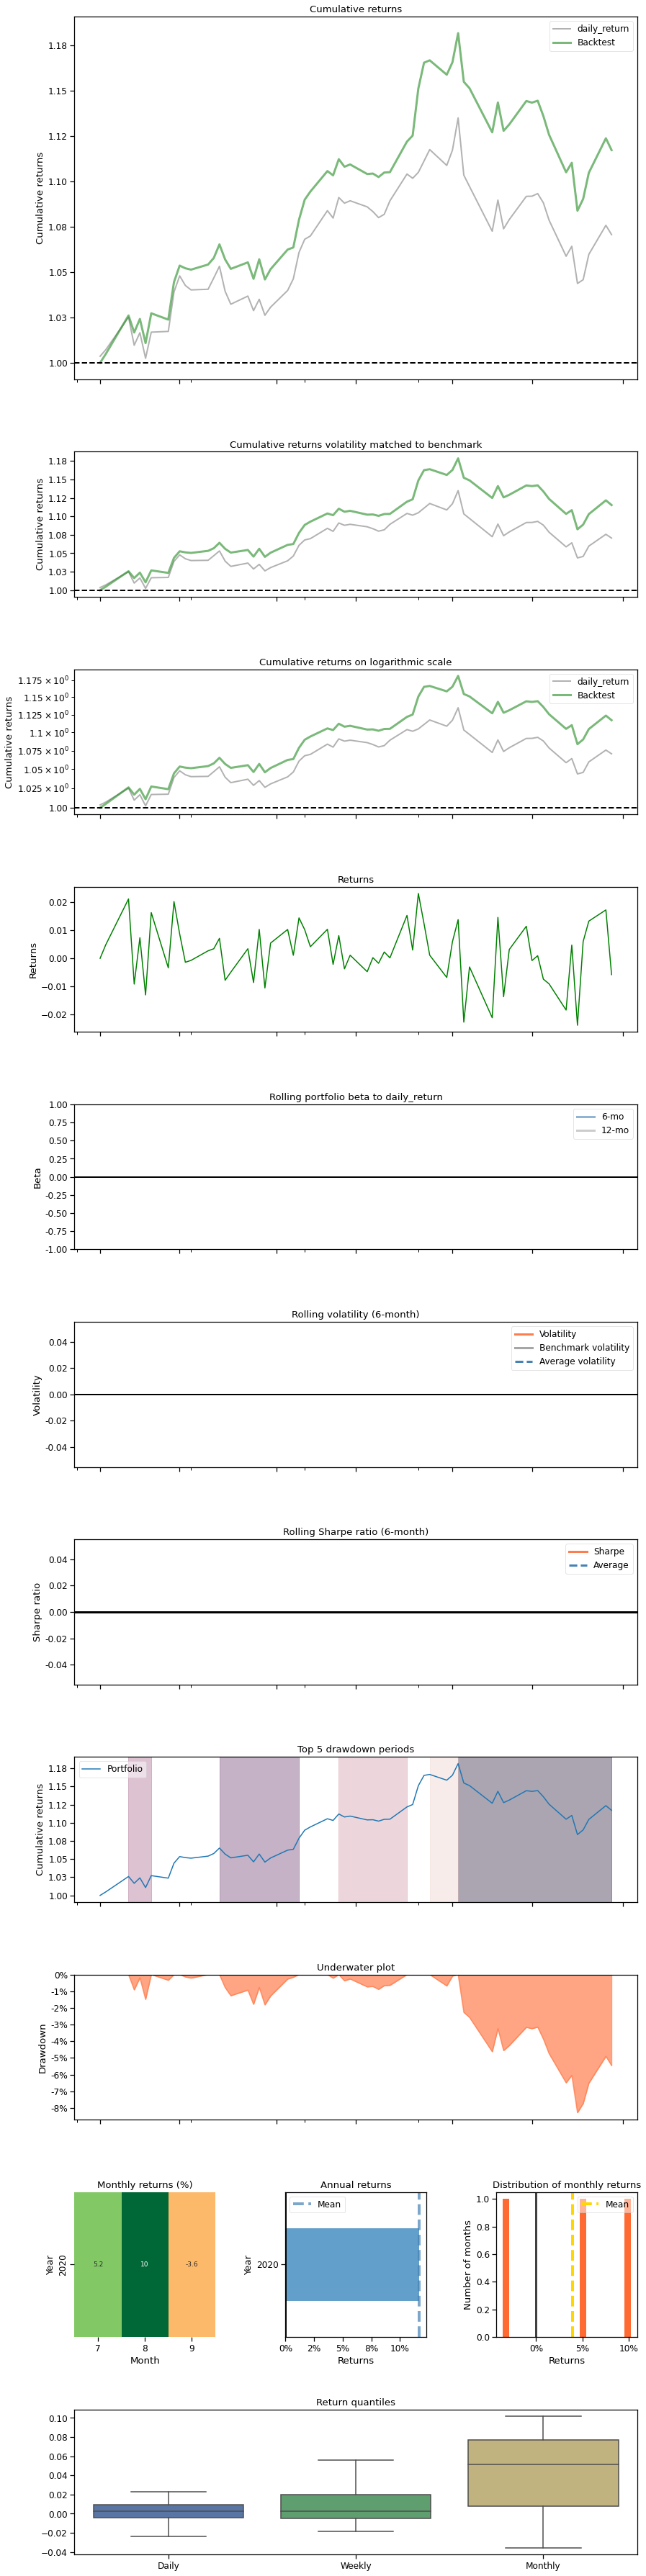

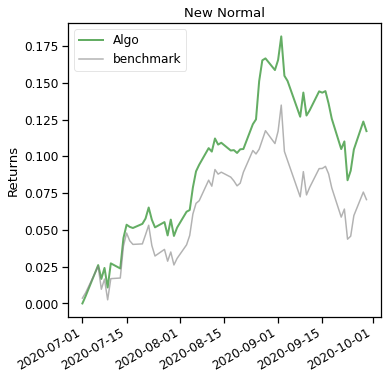

In [42]:
#%matplotlib inline
TD3_mod_OHCLVW.plot_backtest_results(df_benchmark_returns=df_DJI_returns_val)

<AxesSubplot:>

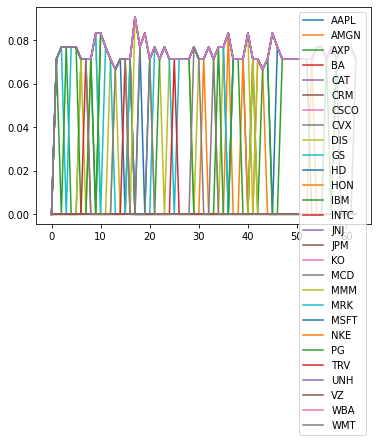

In [43]:
TD3_mod_OHCLVW.pf_weights_hist.plot()

<AxesSubplot:>

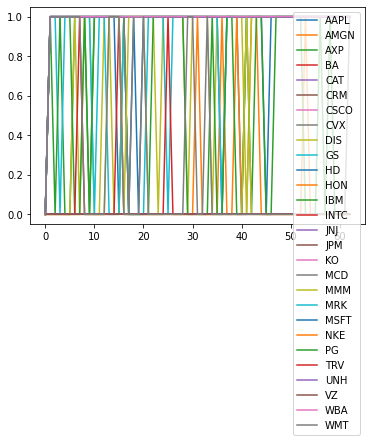

In [44]:
TD3_mod_OHCLVW.agt_action_hist.plot()

## TD3 Mods, Seed = 37

In [8]:
# Env params
n_lookback_prds = 90
pf_value_ini = 1000000
reward_type= 'portfolio_return'
state_struct_list = ['open','high','low','close', 'volume', 'weights']
tech_ind_list = []
transaction_cost_pct = 0
weight_normalization = "relu"

In [9]:
train_env_OHLCVW = PFOptEnv_XP(
            df_X = df_train,
            cov_X = cov_X_train,
            n_lookback_prds = n_lookback_prds,
            pf_value_ini = pf_value_ini,
            reward_type = reward_type,
            state_struct_list = state_struct_list,
            tech_ind_list = tech_ind_list,
            transaction_cost_pct= transaction_cost_pct,
            weight_normalization = weight_normalization)

In [10]:
test_env_OHLCVW = PFOptEnv_XP(
            df_X = df_test,
            cov_X = cov_X_test,
            n_lookback_prds = n_lookback_prds,
            pf_value_ini = pf_value_ini,
            reward_type = reward_type,
            state_struct_list = state_struct_list,
            tech_ind_list = tech_ind_list,
            transaction_cost_pct= transaction_cost_pct,
            weight_normalization = weight_normalization)

In [11]:
eval_env_OHLCVW = PFOptEnv_XP(
            df_X = df_val,
            cov_X = cov_X_val,
            n_lookback_prds = n_lookback_prds,
            pf_value_ini = pf_value_ini,
            reward_type = reward_type,
            state_struct_list = state_struct_list,
            tech_ind_list = tech_ind_list,
            transaction_cost_pct= transaction_cost_pct,
            weight_normalization = weight_normalization)

In [12]:
train_env_OHLCVW.N_periods

2894

In [82]:
del TD3_mod_OHCLVW, eval_callback, stop_training_callback

In [13]:
# Instantiate agent
TD3_mod_OHCLVW = PFOptAgent_XP(train_env = train_env_OHLCVW)

In [14]:
TD3_PARAMS = {"batch_size": 256, 
              "buffer_size": 10000,
              "learning_rate": 0.01,
              "gamma":0,
              "train_freq": (5, "step"),
              "policy_delay":1,
              "learning_starts":5,
              "action_noise":"ornstein_uhlenbeck",}

TD3_mod_OHCLVW.set_model(model_name = "td3_mod",
                     seed = 37,
                     model_kwargs=TD3_PARAMS)

{'batch_size': 256, 'buffer_size': 10000, 'learning_rate': 0.01, 'gamma': 0, 'train_freq': (5, 'step'), 'policy_delay': 1, 'learning_starts': 5, 'action_noise': OrnsteinUhlenbeckActionNoise(mu=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.], sigma=[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1])}
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
td3_mod with given parameters has been successfully created.


True

In [15]:

stop_training_callback = StopTrainingOnNoModelImprovement(max_no_improvement_evals=5,verbose=1)
eval_callback = EvalCallback(eval_env=eval_env_OHLCVW, 
                             eval_freq=int(train_env_OHLCVW.N_periods/2), 
                             callback_after_eval=stop_training_callback, 
                             verbose=1)

In [16]:
loss_dict = TD3_mod_OHCLVW.train_model(tb_log_name='td3_mod',
                                       n_train_rounds=4,
                                       model_callback = eval_callback,
                                      progress_bar = True,
                                      )

Output()

=================================

Initial portfolio value: 1000000

End portfolio value: 1033200.6271722303

Yearly Sharpe ratio at last period: 0.9197713906725764

=================================

=================================

Initial portfolio value: 1000000

End portfolio value: 1033200.6271722303

Yearly Sharpe ratio at last period: 0.9197713906725764

=================================

=================================

Initial portfolio value: 1000000

End portfolio value: 1033200.6271722303

Yearly Sharpe ratio at last period: 0.9197713906725764

=================================

=================================

Initial portfolio value: 1000000

End portfolio value: 1033200.6271722303

Yearly Sharpe ratio at last period: 0.9197713906725764

=================================

=================================

Initial portfolio value: 1000000

End portfolio value: 1033200.6271722303

Yearly Sharpe ratio at last period: 0.9197713906725764

=================================

Eval num_timesteps=1447, episode_reward=0.03 +/- 0.00

Episode length: 63.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 63       |
|    mean_reward     | 0.0288   |
| time/              |          |
|    total_timesteps | 1447     |
| train/             |          |
|    actor_loss      | -6.72    |
|    critic_loss     | 6.06e+06 |
|    learning_rate   | 0.01     |
|    n_updates       | 1440     |
---------------------------------


New best mean reward!

=================================

Initial portfolio value: 1000000

End portfolio value: 5861140.099466748

Yearly Sharpe ratio at last period: 0.9757322394967776

=================================

=================================

Initial portfolio value: 1000000

End portfolio value: 1033200.6271722303

Yearly Sharpe ratio at last period: 0.9197713906725764

=================================

=================================

Initial portfolio value: 1000000

End portfolio value: 1033200.6271722303

Yearly Sharpe ratio at last period: 0.9197713906725764

=================================

=================================

Initial portfolio value: 1000000

End portfolio value: 1033200.6271722303

Yearly Sharpe ratio at last period: 0.9197713906725764

=================================

=================================

Initial portfolio value: 1000000

End portfolio value: 1033200.6271722303

Yearly Sharpe ratio at last period: 0.9197713906725764

=================================

=================================

Initial portfolio value: 1000000

End portfolio value: 1033200.6271722303

Yearly Sharpe ratio at last period: 0.9197713906725764

=================================

Eval num_timesteps=2894, episode_reward=0.03 +/- 0.00

Episode length: 63.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 63       |
|    mean_reward     | 0.0288   |
| time/              |          |
|    total_timesteps | 2894     |
| train/             |          |
|    actor_loss      | -0.785   |
|    critic_loss     | 1.79e+06 |
|    learning_rate   | 0.01     |
|    n_updates       | 2885     |
---------------------------------


=================================

Initial portfolio value: 1000000

End portfolio value: 1033200.6271722303

Yearly Sharpe ratio at last period: 0.9197713906725764

=================================

=================================

Initial portfolio value: 1000000

End portfolio value: 1033200.6271722303

Yearly Sharpe ratio at last period: 0.9197713906725764

=================================

=================================

Initial portfolio value: 1000000

End portfolio value: 1033200.6271722303

Yearly Sharpe ratio at last period: 0.9197713906725764

=================================

=================================

Initial portfolio value: 1000000

End portfolio value: 1033200.6271722303

Yearly Sharpe ratio at last period: 0.9197713906725764

=================================

=================================

Initial portfolio value: 1000000

End portfolio value: 1033200.6271722303

Yearly Sharpe ratio at last period: 0.9197713906725764

=================================

Eval num_timesteps=4341, episode_reward=0.03 +/- 0.00

Episode length: 63.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 63       |
|    mean_reward     | 0.0288   |
| time/              |          |
|    total_timesteps | 4341     |
| train/             |          |
|    actor_loss      | -0.452   |
|    critic_loss     | 2.25e+06 |
|    learning_rate   | 0.01     |
|    n_updates       | 4335     |
---------------------------------


=================================

Initial portfolio value: 1000000

End portfolio value: 5682298.681683709

Yearly Sharpe ratio at last period: 0.9553631769728045

=================================

=================================

Initial portfolio value: 1000000

End portfolio value: 1033200.6271722303

Yearly Sharpe ratio at last period: 0.9197713906725764

=================================

=================================

Initial portfolio value: 1000000

End portfolio value: 1033200.6271722303

Yearly Sharpe ratio at last period: 0.9197713906725764

=================================

=================================

Initial portfolio value: 1000000

End portfolio value: 1033200.6271722303

Yearly Sharpe ratio at last period: 0.9197713906725764

=================================

=================================

Initial portfolio value: 1000000

End portfolio value: 1033200.6271722303

Yearly Sharpe ratio at last period: 0.9197713906725764

=================================

=================================

Initial portfolio value: 1000000

End portfolio value: 1033200.6271722303

Yearly Sharpe ratio at last period: 0.9197713906725764

=================================

Eval num_timesteps=5788, episode_reward=0.03 +/- 0.00

Episode length: 63.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 63       |
|    mean_reward     | 0.0288   |
| time/              |          |
|    total_timesteps | 5788     |
| train/             |          |
|    actor_loss      | 82.4     |
|    critic_loss     | 1.34e+07 |
|    learning_rate   | 0.01     |
|    n_updates       | 5780     |
---------------------------------


=================================

Initial portfolio value: 1000000

End portfolio value: 1033200.6271722303

Yearly Sharpe ratio at last period: 0.9197713906725764

=================================

=================================

Initial portfolio value: 1000000

End portfolio value: 1033200.6271722303

Yearly Sharpe ratio at last period: 0.9197713906725764

=================================

=================================

Initial portfolio value: 1000000

End portfolio value: 1033200.6271722303

Yearly Sharpe ratio at last period: 0.9197713906725764

=================================

=================================

Initial portfolio value: 1000000

End portfolio value: 1033200.6271722303

Yearly Sharpe ratio at last period: 0.9197713906725764

=================================

=================================

Initial portfolio value: 1000000

End portfolio value: 1033200.6271722303

Yearly Sharpe ratio at last period: 0.9197713906725764

=================================

Eval num_timesteps=7235, episode_reward=0.03 +/- 0.00

Episode length: 63.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 63       |
|    mean_reward     | 0.0288   |
| time/              |          |
|    total_timesteps | 7235     |
| train/             |          |
|    actor_loss      | 8.97     |
|    critic_loss     | 2.26e+06 |
|    learning_rate   | 0.01     |
|    n_updates       | 7225     |
---------------------------------


=================================

Initial portfolio value: 1000000

End portfolio value: 5805838.51289399

Yearly Sharpe ratio at last period: 0.9685428257526246

=================================

=================================

Initial portfolio value: 1000000

End portfolio value: 1033200.6271722303

Yearly Sharpe ratio at last period: 0.9197713906725764

=================================

=================================

Initial portfolio value: 1000000

End portfolio value: 1033200.6271722303

Yearly Sharpe ratio at last period: 0.9197713906725764

=================================

=================================

Initial portfolio value: 1000000

End portfolio value: 1033200.6271722303

Yearly Sharpe ratio at last period: 0.9197713906725764

=================================

=================================

Initial portfolio value: 1000000

End portfolio value: 1033200.6271722303

Yearly Sharpe ratio at last period: 0.9197713906725764

=================================

=================================

Initial portfolio value: 1000000

End portfolio value: 1033200.6271722303

Yearly Sharpe ratio at last period: 0.9197713906725764

=================================

Eval num_timesteps=8682, episode_reward=0.03 +/- 0.00

Episode length: 63.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 63       |
|    mean_reward     | 0.0288   |
| time/              |          |
|    total_timesteps | 8682     |
| train/             |          |
|    actor_loss      | 5.06     |
|    critic_loss     | 3.02e+05 |
|    learning_rate   | 0.01     |
|    n_updates       | 8675     |
---------------------------------


=================================

Initial portfolio value: 1000000

End portfolio value: 1033200.6271722303

Yearly Sharpe ratio at last period: 0.9197713906725764

=================================

=================================

Initial portfolio value: 1000000

End portfolio value: 1033200.6271722303

Yearly Sharpe ratio at last period: 0.9197713906725764

=================================

=================================

Initial portfolio value: 1000000

End portfolio value: 1033200.6271722303

Yearly Sharpe ratio at last period: 0.9197713906725764

=================================

=================================

Initial portfolio value: 1000000

End portfolio value: 1033200.6271722303

Yearly Sharpe ratio at last period: 0.9197713906725764

=================================

=================================

Initial portfolio value: 1000000

End portfolio value: 1033200.6271722303

Yearly Sharpe ratio at last period: 0.9197713906725764

=================================

Eval num_timesteps=10129, episode_reward=0.03 +/- 0.00

Episode length: 63.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 63       |
|    mean_reward     | 0.0288   |
| time/              |          |
|    total_timesteps | 10129    |
| train/             |          |
|    actor_loss      | -3.37    |
|    critic_loss     | 2.86e+05 |
|    learning_rate   | 0.01     |
|    n_updates       | 10120    |
---------------------------------


Stopping training because there was no new best model in the last 6 evaluations

In [17]:
%matplotlib inline

In [18]:
len(loss_dict["actor_losses"])

5

<AxesSubplot:>

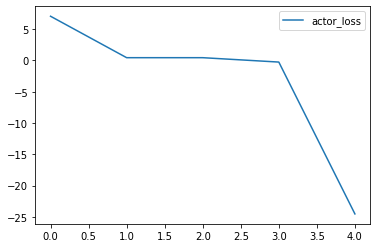

In [19]:
pd.DataFrame({"actor_loss":loss_dict["actor_losses"]}).plot()

In [20]:
loss_dict["critic_losses"]

[127460.5390625, 242052.359375, 276014.875, 225027.65625, 557981.1875]

<AxesSubplot:>

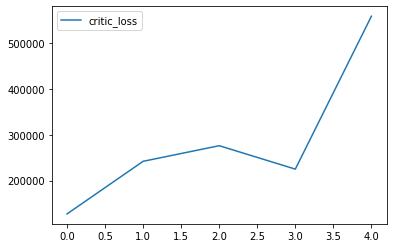

In [21]:
pd.DataFrame({"critic_loss":loss_dict["critic_losses"]}).plot()

In [22]:
df_pf_value_hist_det, df_pf_return_hist_det, \
df_pf_weights_hist_det, df_agt_action_hist_det\
 = TD3_mod_OHCLVW.run_backtest(test_env = test_env_OHLCVW,)

Initial portfolio value: 1000000
End portfolio value: 1299542.4658634306
Yearly Sharpe ratio at last period: 1.68586223903368
Finished running backtest. Storing results...


In [41]:
df_pf_value_hist_det, df_pf_return_hist_det, \
df_pf_weights_hist_det, df_agt_action_hist_det\
 = TD3_mod_OHCLVW.run_backtest(test_env = eval_env_OHLCVW,)

Initial portfolio value: 1000000
End portfolio value: 1601091.9968540422
Yearly Sharpe ratio at last period: 2.7480577501470793
Finished running backtest. Storing results...


Start date,2020-07-01
End date,2021-09-01
Total months,14
,Backtest
Annual return,25.0%
Cumulative returns,30.0%
Annual volatility,13.8%
Sharpe ratio,1.68
Calmar ratio,2.79
Stability,0.92
Max drawdown,-8.9%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,8.95,2020-09-02,2020-10-30,2020-11-10,50
1,3.82,2021-02-24,2021-03-04,2021-03-10,11
2,3.68,2021-06-04,2021-06-18,2021-08-03,43
3,3.51,2020-07-22,2020-07-30,2020-08-10,14
4,3.36,2021-01-21,2021-01-29,2021-02-05,12


Stress Events,mean,min,max
New Normal,0.09%,-3.05%,3.49%


True

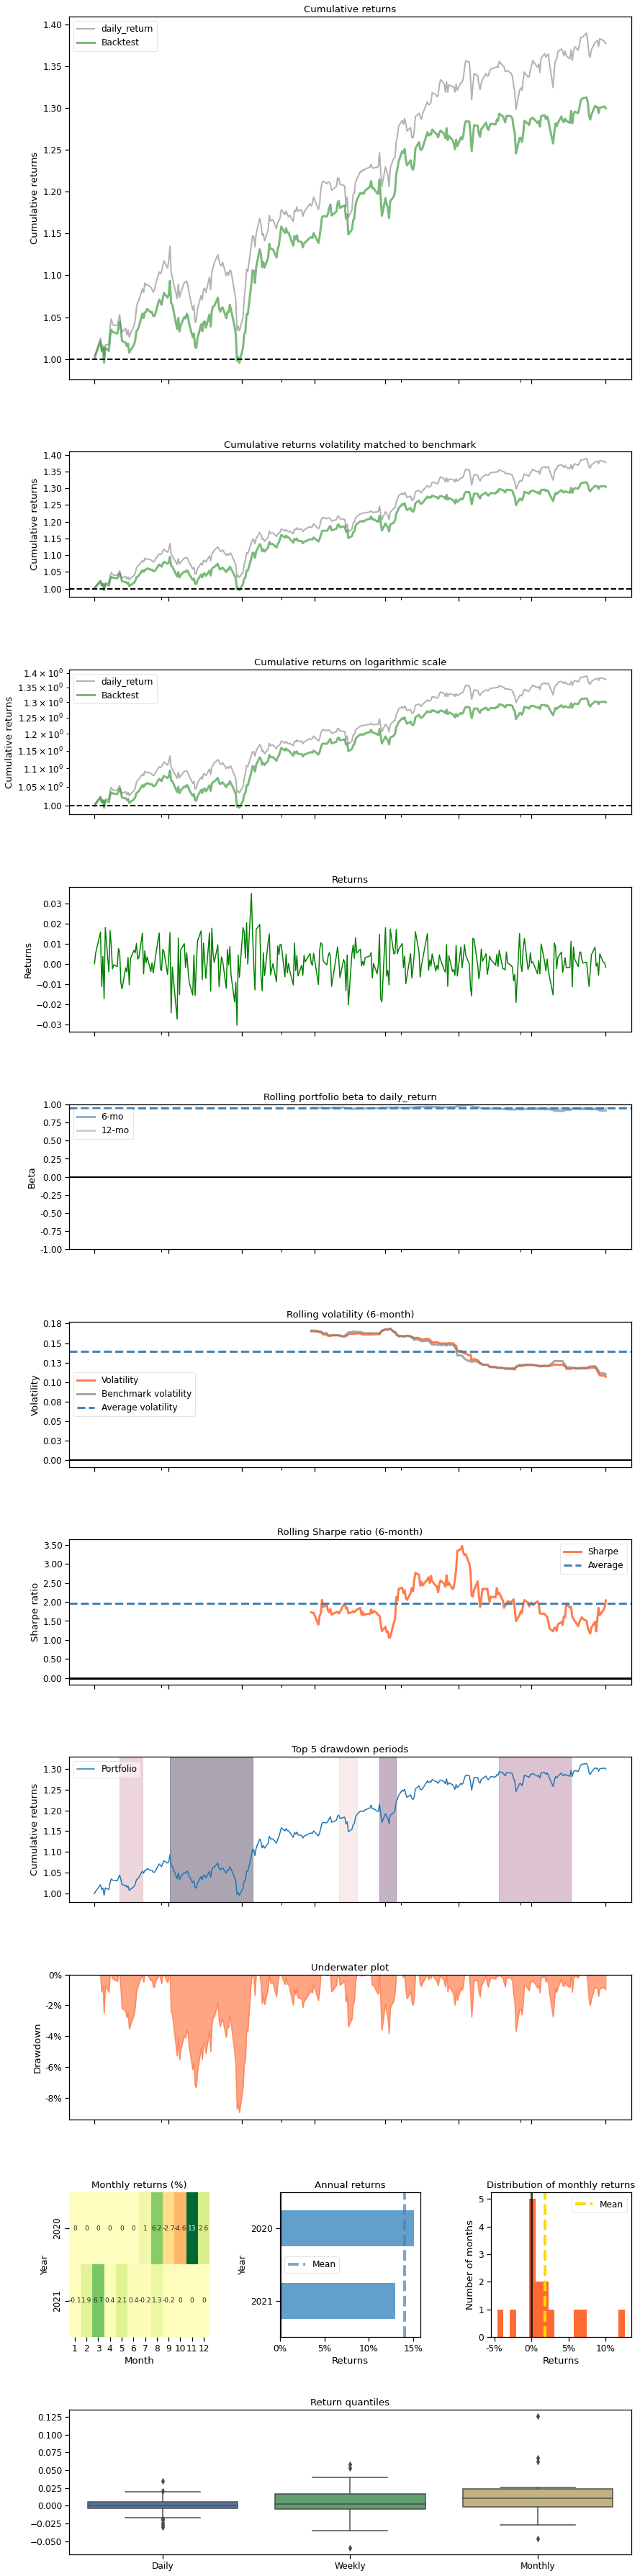

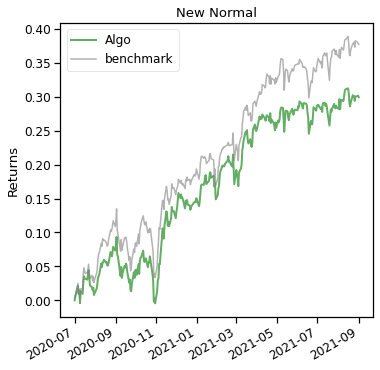

In [23]:
#%matplotlib inline
TD3_mod_OHCLVW.plot_backtest_results(df_benchmark_returns=df_DJI_returns)

<AxesSubplot:>

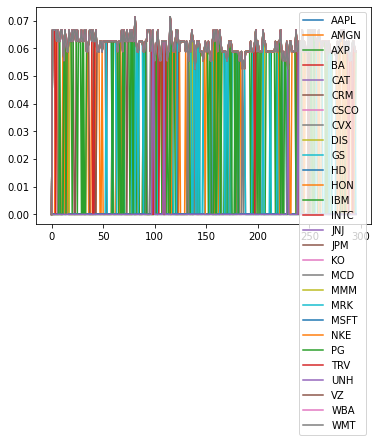

In [69]:
TD3_mod_OHCLVW.pf_weights_hist.plot()

<AxesSubplot:>

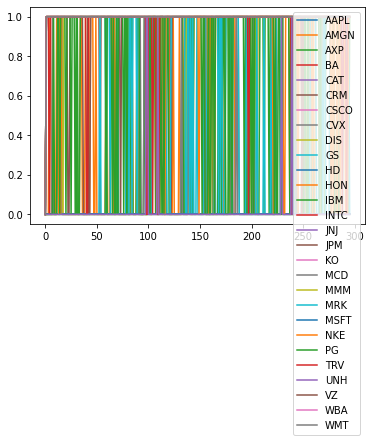

In [70]:
TD3_mod_OHCLVW.agt_action_hist.plot()